In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

#seeds
rnd_seed = 23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [4]:
# Visualizacion
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.as_node_interactivity = 'all'

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth',400)

from matplotlib import rcParams
sns.set(context='notebook'
       ,style = 'whitegrid'
       ,rc={'figure.figsize':(18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Spark

In [7]:
#Session
spark = SparkSession.builder \
        .master("local") \
        .appName('LR-CaliforniaHousing') \
        .getOrCreate()
#SparkContext
sc = spark.sparkContext

In [10]:
sc

<SparkContext master=local appName=LR-CaliforniaHousing>

# Data

In [144]:
path = './data/cal_housing.data'

schema = StructType ([
    
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medianAge", FloatType(), nullable=True),
    StructField("totalRoom", FloatType(), nullable=True),
    StructField("totalBedroom", FloatType(), nullable=True),
    StructField("population", FloatType(), nullable=True),
    StructField("household", FloatType(), nullable=True),
    StructField("medianIncome", FloatType(), nullable=True),
    StructField("medianHouseValue", FloatType(), nullable=True)
    
    ])

data = spark.read \
        .csv(path=path, schema = schema) \
        .cache()

data.printSchema()
print(f'rows: {data.count()}')

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medianAge: float (nullable = true)
 |-- totalRoom: float (nullable = true)
 |-- totalBedroom: float (nullable = true)
 |-- population: float (nullable = true)
 |-- household: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- medianHouseValue: float (nullable = true)

rows: 20640


In [145]:
data.limit(5).toPandas()

,long,lat,medianAge,totalRoom,totalBedroom,population,household,medianIncome,medianHouseValue
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


### Distribucion de población según mediana de edad

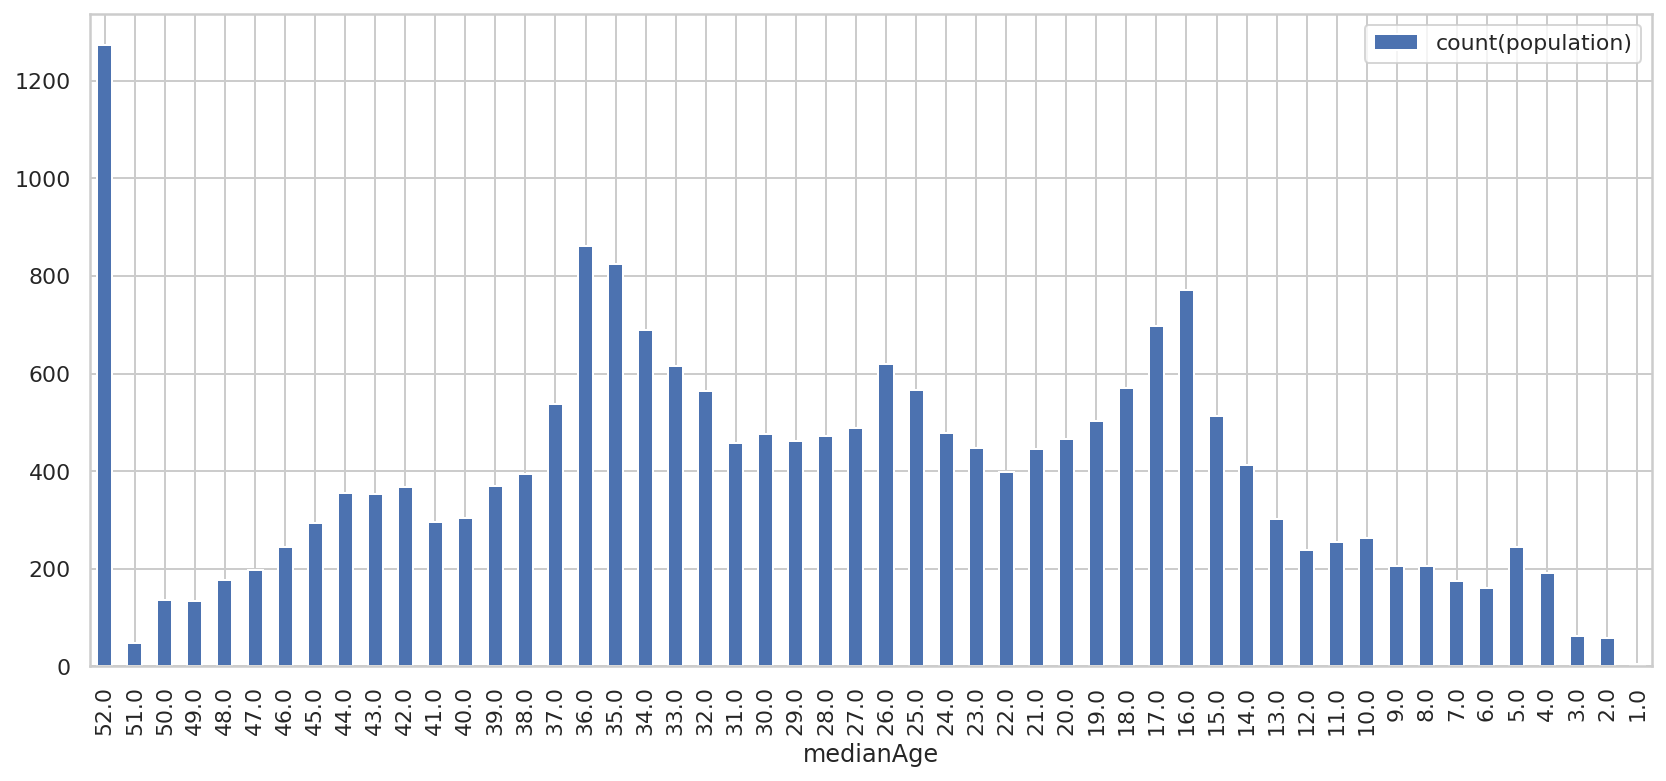

In [146]:
dist1 = data.groupby(['medianAge'])\
    .agg({'population':'count'}) \
    .sort('medianAge', ascending=False)

dist1.toPandas().plot\
     .bar(x='medianAge', 
          figsize=(14,6)
         )
plt.show()

### Resumen del dataset

In [147]:
data.describe()\
    .select(
        'summary',
        F.round('medianAge',2).alias('medianAge'),
        F.round('totalRoom',2).alias('totalRoom'),
        F.round('totalBedroom',2).alias('totalBedroom'),
        F.round('population',2).alias('population'),
        F.round('household',2).alias('household'),
        F.round('medianIncome',2).alias('medianIncome'),
        F.round('medianHouseValue',2).alias('medianHouseValue')
    ) \
    .toPandas().set_index('summary')

,medianAge,totalRoom,totalBedroom,population,household,medianIncome,medianHouseValue
summary,,,,,,,
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,28.64,2635.76,537.90,1425.48,499.54,3.87,206855.82
stddev,12.59,2181.62,421.25,1132.46,382.33,1.90,115395.62
min,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
max,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


### Manipulación de data

In [153]:
# medianHouseValue, base = 100.000
dataWrangling = data.withColumn('medianHouseValue',col('medianHouseValue')/100000)

# room per household, population per household, bedroom per rooms
dataWrangling = dataWrangling.withColumn('roomPerHousehold', 
                        F.round(col('totalRoom')/col('household'),2)
                      )\
            .withColumn('populationPerHousehold',
                       F.round(col('population')/col('household'),2)
                       )\
            .withColumn('beedroomPerHousehold',
                       F.round(col('totalBedroom')/col('totalRoom'),2)
                       )

In [149]:
dataWrangling.limit(3).toPandas()

,long,lat,medianAge,totalRoom,totalBedroom,population,household,medianIncome,medianHouseValue,roomPerHousehold,populationPerHousehold,beedroomPerHousehold
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,4.526,6.98,2.56,0.15
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.585,6.24,2.11,0.16
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,3.521,8.29,2.80,0.13


# Modelado

### Vector de features

In [155]:
features = ['totalBedroom',
            'population',
            'household',
            'medianIncome',
            'roomPerHousehold',
            'populationPerHousehold',
            'beedroomPerHousehold']
assembler = VectorAssembler(
                inputCols=features,
                outputCol='features'
            )

dataModel = assembler.transform(dataWrangling)


standardScaler = StandardScaler(
                    inputCol='features',
                    outputCol='featuresScaled'
                )

dataModel = standardScaler.fit(dataModel) \
                .transform(dataModel)

dataModel = dataModel.select('featuresScaled','medianHouseValue')

In [156]:
dataModel.limit(3).toPandas()

,featuresScaled,medianHouseValue
0,"[0.30623297630686513, 0.2843362208866199, 0.3295584480852433, 4.38209543579743, 2.8211223886115664, 0.24648542140099877, 2.5828740130262697]",4.526
1,"[2.6255323394991694, 2.1201592122632746, 2.9764882057222772, 4.36956799913841, 2.522034914747303, 0.20315790592035446, 2.755065613894688]",3.585
2,"[0.451040817816313, 0.4379837439744208, 0.4629511532626037, 3.820042673324032, 3.3505880518037077, 0.2695934296573424, 2.238490811289434]",3.521


### Ajuste de modelo

In [165]:
train, test = dataModel.randomSplit([.8,.2],
                                    seed=rnd_seed)

In [169]:
lr = LinearRegression(
            featuresCol='featuresScaled',
            labelCol='medianHouseValue',
            predictionCol='prediction',
            maxIter=100,
            regParam=0.3,
            elasticNetParam=0.8,
            standardization=False
            )
lrModel = lr.fit(train)

In [187]:
coeff = pd.DataFrame({
        'Feature': ['Intercept'] + features,
        'Coeff': np.insert(lrModel.coefficients.toArray(), 0, lrModel.intercept)
})

coeff

,Feature,Coeff
0,Intercept,0.999106
1,totalBedroom,0.000000
2,population,0.000000
3,household,0.000000
4,medianIncome,0.524366
5,roomPerHousehold,0.000000
6,populationPerHousehold,0.000000
7,beedroomPerHousehold,0.000000


### Perfomance

In [194]:
predictions = (lrModel.transform(test)).select('prediction','medianHouseValue')
predictions.limit(3).toPandas()

,prediction,medianHouseValue
0,5.139256,5.00001
1,2.275644,2.50000
2,1.309615,0.60000


In [200]:
print(f'RMSE: {np.round(lrModel.summary.rootMeanSquaredError,3)}')
print(f'MAE: {np.round(lrModel.summary.meanAbsoluteError,3)}')
print(f'R2: {np.round(lrModel.summary.r2,3)}')

RMSE: 0.881
MAE: 0.678
R2: 0.415


#### pyspark RegressionEvaluator

In [205]:
rmse = RegressionEvaluator(
            predictionCol='prediction',
            labelCol='medianHouseValue',
            metricName='rmse'
            )
print(f'RMSE: {np.round(rmse.evaluate(predictions),3)}')


mae = RegressionEvaluator(
            predictionCol='prediction',
            labelCol='medianHouseValue',
            metricName='mae'
            )
print(f'MAE: {np.round(mae.evaluate(predictions),3)}')

RMSE: 0.874
MAE: 0.671


#### pyspark RegressionMetrics

In [212]:
metrics = RegressionMetrics(predictions.rdd)

print(f'RMSE: {np.round(metrics.rootMeanSquaredError,3)}')
print(f'MAE: {np.round(metrics.meanAbsoluteError,3)}')

RMSE: 0.874
MAE: 0.671


In [213]:
spark.stop()